In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirdesign, iirfilter, freqs, tf2zpk
import math
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')
from matplotlib.figure import figaspect
from dataclasses import dataclass
from enum import Enum
from typing import List

11 [-1.49011612e-08+8.03299363e+08j -1.49011612e-08-8.03299363e+08j
  3.72529030e-08+2.76798096e+08j  3.72529030e-08-2.76798096e+08j
 -7.45058060e-09+1.77715318e+08j -7.45058060e-09-1.77715318e+08j
 -2.79396772e-09+1.41035675e+08j -2.79396772e-09-1.41035675e+08j
 -5.58793545e-09+1.27230120e+08j -5.58793545e-09-1.27230120e+08j] [-1.56341434e+08+4.08636010e+07j -1.56341434e+08-4.08636010e+07j
 -1.08461193e+08+9.11990444e+07j -1.08461193e+08-9.11990444e+07j
 -6.26581465e+07+1.03401675e+08j -6.26581465e+07-1.03401675e+08j
 -9.62507912e+06+1.00286350e+08j -9.62507912e+06-1.00286350e+08j
 -3.16252300e+07+1.02427799e+08j -3.16252300e+07-1.02427799e+08j] 0.0017782794100389243


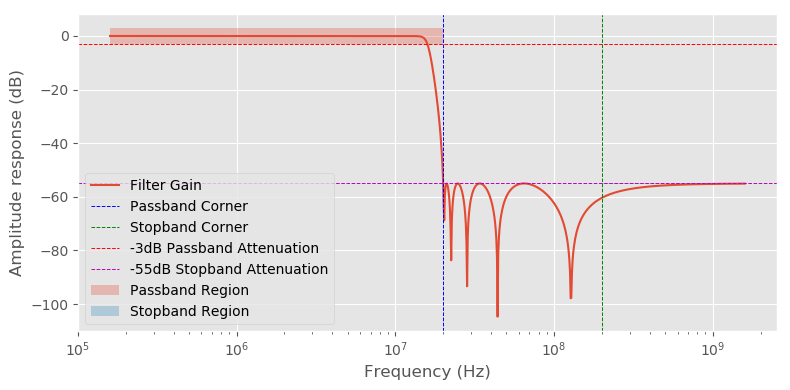

In [29]:
@dataclass(frozen=True)
class LPFSpec:
    passband_corner_freq: int # In radians/sec
    stopband_corner_freq: int # In radians/sec
    stopband_attenuation: int # In dB down from 0dB
    passband_ripple: int # In dB
    group_delay_variation: int # In nanoseconds, maximum variation of group delay from low-freq to passband corner
    
    def __post_init__(self):
        assert self.passband_ripple > 0, "Can't have 0 ripple in the passband"
        assert self.stopband_attenuation > 0, "Attenuation should be given as a positive number (-50dBc => stopband_atten = 50)"

class FilterType(Enum):
    BUTTERWORTH = 'butter'
    CHEBYSHEV1 = 'cheby1'
    CHEBYSHEV2 = 'cheby2'
    ELLIPTIC = 'ellip'
    BESSEL = 'bessel'
    
@dataclass(frozen=True)
class ZPK:
    Z: List[complex]
    P: List[complex]
    K: float
        
@dataclass(frozen=True)
class BA:
    B: List[complex]
    A: List[complex]
    def to_zpk(self) -> ZPK:
        zpk = scipy.signal.tf2zpk(self.B, self.A)
        return ZPK(zpk[0], zpk[1], zpk[2])
        
# Design a minimum order LPF of filter type 'ftype'.
# The function will increase the filter order until the stopband attenuation spec is met.
# passband_corner, stopband_corner in radians/sec
# stopband_atten should be positive in dBc
def design_lpf(passband_corner, stopband_corner, stopband_atten, passband_ripple, ftype='butter'):
    assert passband_ripple > 0, "Can't have 0 ripple in the passband"
    assert stopband_atten > 0, "Attenuation should be given as a positive number (-50dBc => stopband_atten = 50)"
    order = 2
    while True:
        b, a = iirfilter(
            N = order,
            Wn = [passband_corner],
            rp = passband_ripple,
            rs = stopband_atten,
            btype = 'lowpass',
            analog = True,
            ftype=ftype,
            output='ba')
        w1, h1 = freqs(b, a, worN=[stopband_corner])
        w2, h2 = freqs(b, a, worN=[passband_corner])
        if (-20*np.log10(abs(h1[0])) > stopband_atten) and (20*np.log10(abs(h2[0])) > -3):
            return order, b, a
        else:
            order = order + 1
            
        if order > 10:
            return order, b, a

order, b, a = design_lpf(2*math.pi*20e6, 2*math.pi*200e6, 55, 1, ftype=FilterType.CHEBYSHEV2.value)
w, h = freqs(b, a, worN=np.logspace(6, 10, 1000))
f = w / (2*math.pi)
db = 20*np.log10(abs(h))
width, height = figaspect(0.5)
fig, ax = plt.subplots(figsize=(width,height))
plt.semilogx(f, db, linewidth=1.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude response (dB)')
plt.axvline(x=20e6, linestyle = '--', linewidth=0.7, color='b')
plt.axvline(x=200e6, linestyle = '--', linewidth=0.7, color='g')
plt.axhline(y=-3, linestyle = '--', linewidth=0.7, color='r')
plt.axhline(y=-55, linestyle = '--', linewidth=0.7, color='m')
plt.grid(True)
ax.fill([f[0], 20e6, 20e6, f[0]], [3, 3, -3, -3], alpha=0.3)
ax.fill([200e6, f[-1], f[-1], 200e6], [-55, -55, db[-1], db[-1]], alpha=0.3)
plt.legend(['Filter Gain', 'Passband Corner', 'Stopband Corner', '-3dB Passband Attenuation',
            '-55dB Stopband Attenuation', 'Passband Region', 'Stopband Region'])
plt.tight_layout()
plt.savefig('plot.pdf')
z, p, k = tf2zpk(b, a)
print(order, z, p, k)

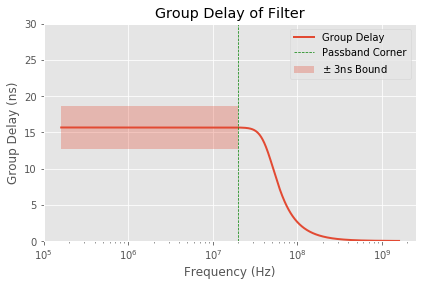

In [16]:
group_delay = (-np.diff(np.unwrap(np.angle(h))) / np.diff(w)) * 1e9
width, height = figaspect(0.6)
fig, ax = plt.subplots(figsize=(width,height))
plt.semilogx(f[1:], group_delay, linewidth=2)
plt.axvline(x=20e6, linestyle = '--', linewidth=0.7, color='g')
ax.fill([f[0], 20e6, 20e6, f[0]], [group_delay[0] + 3, group_delay[0] + 3, group_delay[0] - 3, group_delay[0] - 3],
        alpha=0.3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Group Delay (ns)')
plt.title('Group Delay of Filter')
plt.legend(['Group Delay', 'Passband Corner', '$\pm$ 3ns Bound'])
plt.ylim(0, 30)
plt.show()